link to my Github repo: https://github.com/SUN-Wenjun/Advanced_Machine_Learning_Assignment/tree/master/Assignment1

# Assignment 1

We used countries as a categorical variable during our in class mini-hackathon.   This variable actually is categorical at the observation level.  Suffice it to say, in practice we do not really want to build a categorical variable using a variable that has as many categories as it we have observations in our dataset. 

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import seed
seed(5074)
import tensorflow
tensorflow.random.set_seed(5074)

## 0. Merge datasets, add region

Before building your model replace the variable denoting country names with a new variable denoting world regions.  Here is a dataset you can use to merge in this data: https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv

In [79]:
data = pd.read_csv("data/worldhappiness2019.csv")

regiondata = pd.read_csv("data/region.csv")


mergedata = pd.merge(data, regiondata, how='left', left_on='Country or region', right_on='name')
# Check for missing values (there won't be any given that I have already cleaned up the region data)
mergedata.loc[pd.isnull(mergedata).iloc[:,9]].to_csv("missing.csv",index=False)

# clean up final region data
X = mergedata.drop(['Happiness_level', 'name', 'Country or region', 'sub-region'],axis=1)

In [80]:
X.head()

,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,region
0,1.340,1.587,0.986,0.596,0.153,0.393,Europe
1,1.383,1.573,0.996,0.592,0.252,0.410,Europe
2,1.488,1.582,1.028,0.603,0.271,0.341,Europe
3,1.380,1.624,1.026,0.591,0.354,0.118,Europe
4,1.396,1.522,0.999,0.557,0.322,0.298,Europe


In [81]:
y = mergedata['Happiness_level']

## 1. Explore bivariate results (Use visualizations!)

Describe any relationships you see between particular features and the target variable

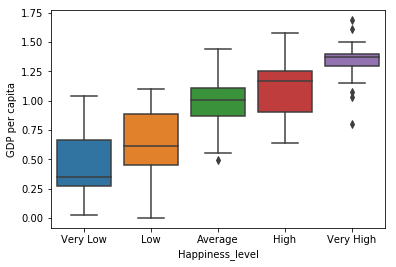

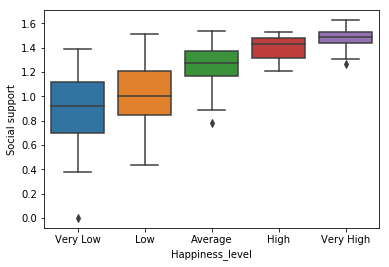

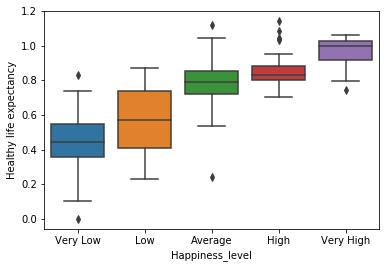

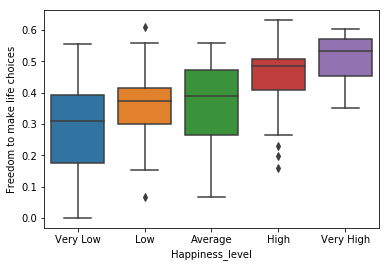

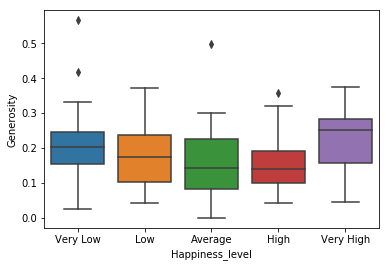

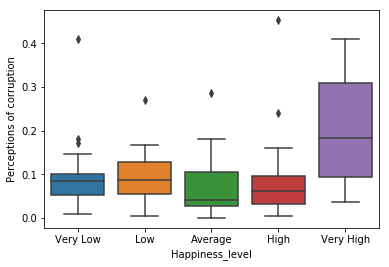

In [82]:
features = ['GDP per capita','Social support', 'Healthy life expectancy','Freedom to make life choices', 'Generosity', 'Perceptions of corruption']
for feature in features:
    ax = sns.boxplot(x='Happiness_level', y=feature, 
                     data=mergedata, 
                     order=['Very Low', 'Low', 'Average', 'High', 'Very High'])
    plt.show()

Answer:

Variables that show a positive correlation with happiness level includes: GDP per capita, Social support, Healthy life expectancy, Freedom to make life choices. In other words, as these variables go higher, happiness level goes higher too.

Generosity and Perceptions of corruption seem to have no clear correlation with happiness level from the box plots. Although it is interesting to find that countries with 'very high' level of happiness show a slightly higher perceptions of corruption, the varietion of this observation is relatively high. 




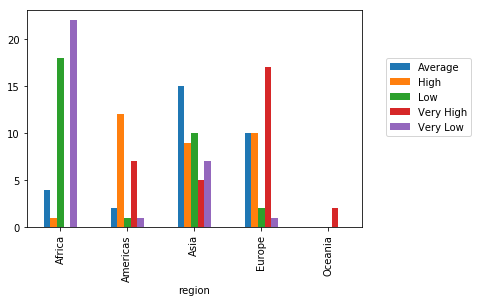

In [83]:
df = pd.crosstab(mergedata['region'], mergedata['Happiness_level'])

ax = df.plot.bar()
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.8), ncol=1)

plt.show()

Answer:

When it comes to region, most countries in Europe have 'very high' happiness level, while countries in Africa are more in the range of 'very low' and 'low' level of happiness.

## 2. Examine features that predict happiness categories using one or more models that allow for automatic feature selection

Explain any meaningful findings

### preprocess data

In [84]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [85]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

numeric_features=X.columns.tolist()
numeric_features.remove('region')

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


#Fit your preprocessor object
prediction_input_preprocessor=preprocessor.fit(X_train) 

import pickle
pickle.dump(prediction_input_preprocessor, open( "preprocessor.pkl", "wb" ) )

### fit a random forest model that allow for feature selection

In [86]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

In [87]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 1000))
sel.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train))

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
        max_features=None, norm_order=1, prefit=False, threshold=None)

Here, SelectFromModel will select the features whose importance is greater than the mean importance of all the features.

In [88]:
sel.get_support()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False])

Answer:

According to the result of feature selection, all the region (dummy) variables are considered less important for predicting happiness level than the average level of all the features.



## 3. Run at least three prediction models to try to predict World Happiness well.

### Model 1

In [89]:
prediction_input_preprocessor.transform(X_train).shape

(117, 11)

In [90]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model1 = Sequential()
model1.add(Dense(124, input_dim=11, activation='relu'))
model1.add(Dense(124, activation='relu'))
model1.add(Dense(124, activation='relu'))

model1.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model1.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 300)  

Epoch 1/300
117/117 [==============================] - 0s 443us/step - loss: 1.6086 - accuracy: 0.1966
Epoch 2/300
117/117 [==============================] - 0s 43us/step - loss: 1.6018 - accuracy: 0.2137
Epoch 3/300
117/117 [==============================] - 0s 43us/step - loss: 1.5950 - accuracy: 0.2222
Epoch 4/300
117/117 [==============================] - 0s 51us/step - loss: 1.5881 - accuracy: 0.2222
Epoch 5/300
117/117 [==============================] - 0s 51us/step - loss: 1.5811 - accuracy: 0.2308
Epoch 6/300
117/117 [==============================] - 0s 34us/step - loss: 1.5745 - accuracy: 0.2222
Epoch 7/300
117/117 [==============================] - 0s 43us/step - loss: 1.5684 - accuracy: 0.2479
Epoch 8/300
117/117 [==============================] - 0s 34us/step - loss: 1.5615 - accuracy: 0.2650
Epoch 9/300
117/117 [==============================] - 0s 43us/step - loss: 1.5553 - accuracy: 0.2650
Epoch 10/300
117/117 [==============================] - 0s 43us/step - loss: 1.54

117/117 [==============================] - 0s 43us/step - loss: 1.1805 - accuracy: 0.5299
Epoch 81/300
117/117 [==============================] - 0s 60us/step - loss: 1.1762 - accuracy: 0.5214
Epoch 82/300
117/117 [==============================] - 0s 43us/step - loss: 1.1726 - accuracy: 0.5299
Epoch 83/300
117/117 [==============================] - 0s 51us/step - loss: 1.1686 - accuracy: 0.5299
Epoch 84/300
117/117 [==============================] - 0s 34us/step - loss: 1.1643 - accuracy: 0.5299
Epoch 85/300
117/117 [==============================] - 0s 34us/step - loss: 1.1604 - accuracy: 0.5299
Epoch 86/300
117/117 [==============================] - 0s 43us/step - loss: 1.1565 - accuracy: 0.5385
Epoch 87/300
117/117 [==============================] - 0s 43us/step - loss: 1.1530 - accuracy: 0.5385
Epoch 88/300
117/117 [==============================] - 0s 51us/step - loss: 1.1492 - accuracy: 0.5470
Epoch 89/300
117/117 [==============================] - 0s 34us/step - loss: 1.1451 - 

117/117 [==============================] - 0s 43us/step - loss: 0.9651 - accuracy: 0.5897
Epoch 159/300
117/117 [==============================] - 0s 43us/step - loss: 0.9632 - accuracy: 0.5897
Epoch 160/300
117/117 [==============================] - 0s 51us/step - loss: 0.9618 - accuracy: 0.5897
Epoch 161/300
117/117 [==============================] - 0s 51us/step - loss: 0.9598 - accuracy: 0.5897
Epoch 162/300
117/117 [==============================] - 0s 43us/step - loss: 0.9579 - accuracy: 0.5897
Epoch 163/300
117/117 [==============================] - 0s 43us/step - loss: 0.9565 - accuracy: 0.5897
Epoch 164/300
117/117 [==============================] - 0s 51us/step - loss: 0.9545 - accuracy: 0.5983
Epoch 165/300
117/117 [==============================] - 0s 51us/step - loss: 0.9528 - accuracy: 0.5983
Epoch 166/300
117/117 [==============================] - 0s 43us/step - loss: 0.9510 - accuracy: 0.5897
Epoch 167/300
117/117 [==============================] - 0s 43us/step - loss: 

117/117 [==============================] - 0s 60us/step - loss: 0.8592 - accuracy: 0.6410
Epoch 237/300
117/117 [==============================] - 0s 43us/step - loss: 0.8580 - accuracy: 0.6410
Epoch 238/300
117/117 [==============================] - 0s 51us/step - loss: 0.8568 - accuracy: 0.6410
Epoch 239/300
117/117 [==============================] - 0s 43us/step - loss: 0.8559 - accuracy: 0.6325
Epoch 240/300
117/117 [==============================] - 0s 43us/step - loss: 0.8546 - accuracy: 0.6410
Epoch 241/300
117/117 [==============================] - 0s 43us/step - loss: 0.8537 - accuracy: 0.6410
Epoch 242/300
117/117 [==============================] - 0s 43us/step - loss: 0.8526 - accuracy: 0.6496
Epoch 243/300
117/117 [==============================] - 0s 34us/step - loss: 0.8517 - accuracy: 0.6496
Epoch 244/300
117/117 [==============================] - 0s 34us/step - loss: 0.8506 - accuracy: 0.6496
Epoch 245/300
117/117 [==============================] - 0s 43us/step - loss: 

In [91]:
prediction_index=model1.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [92]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt

def model_eval_metrics(y_true, y_pred,classification="TRUE"):
     if classification=="TRUE":
        accuracy_eval = accuracy_score(y_true, y_pred)
        f1_score_eval = f1_score(y_true, y_pred,average="macro")
        precision_eval = precision_score(y_true, y_pred,average="macro")
        recall_eval = recall_score(y_true, y_pred,average="macro")
        mse_eval = 0
        rmse_eval = 0
        mae_eval = 0
        r2_eval = 0
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     else:
        accuracy_eval = 0
        f1_score_eval = 0
        precision_eval = 0
        recall_eval = 0
        mse_eval = mean_squared_error(y_true, y_pred)
        rmse_eval = sqrt(mean_squared_error(y_true, y_pred))
        mae_eval = mean_absolute_error(y_true, y_pred)
        r2_eval = r2_score(y_true, y_pred)
        metricdata = {'accuracy': [accuracy_eval], 'f1_score': [f1_score_eval], 'precision': [precision_eval], 'recall': [recall_eval], 'mse': [mse_eval], 'rmse': [rmse_eval], 'mae': [mae_eval], 'r2': [r2_eval]}
        finalmetricdata = pd.DataFrame.from_dict(metricdata)
     return finalmetricdata

modelevalobject1 = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject1

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.641026,0.63916,0.660476,0.700455,0,0,0,0


### Model 2

In [93]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model2 = Sequential()
model2.add(Dense(32, input_dim=11, activation='relu')) # change dense to 32
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))

model2.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model2.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model2.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 300)  

Epoch 1/300
117/117 [==============================] - 0s 443us/step - loss: 1.5979 - accuracy: 0.2308
Epoch 2/300
117/117 [==============================] - 0s 34us/step - loss: 1.5912 - accuracy: 0.2308
Epoch 3/300
117/117 [==============================] - 0s 34us/step - loss: 1.5848 - accuracy: 0.2308
Epoch 4/300
117/117 [==============================] - 0s 43us/step - loss: 1.5788 - accuracy: 0.2308
Epoch 5/300
117/117 [==============================] - 0s 34us/step - loss: 1.5728 - accuracy: 0.2479
Epoch 6/300
117/117 [==============================] - 0s 42us/step - loss: 1.5672 - accuracy: 0.2650
Epoch 7/300
117/117 [==============================] - 0s 26us/step - loss: 1.5615 - accuracy: 0.2650
Epoch 8/300
117/117 [==============================] - 0s 43us/step - loss: 1.5564 - accuracy: 0.2906
Epoch 9/300
117/117 [==============================] - 0s 298us/step - loss: 1.5510 - accuracy: 0.3077
Epoch 10/300
117/117 [==============================] - 0s 34us/step - loss: 1.5

117/117 [==============================] - 0s 34us/step - loss: 1.2520 - accuracy: 0.4530
Epoch 81/300
117/117 [==============================] - 0s 43us/step - loss: 1.2487 - accuracy: 0.4530
Epoch 82/300
117/117 [==============================] - 0s 34us/step - loss: 1.2450 - accuracy: 0.4530
Epoch 83/300
117/117 [==============================] - 0s 60us/step - loss: 1.2414 - accuracy: 0.4530
Epoch 84/300
117/117 [==============================] - 0s 34us/step - loss: 1.2379 - accuracy: 0.4530
Epoch 85/300
117/117 [==============================] - 0s 34us/step - loss: 1.2344 - accuracy: 0.4530
Epoch 86/300
117/117 [==============================] - 0s 34us/step - loss: 1.2309 - accuracy: 0.4530
Epoch 87/300
117/117 [==============================] - 0s 43us/step - loss: 1.2277 - accuracy: 0.4530
Epoch 88/300
117/117 [==============================] - 0s 34us/step - loss: 1.2241 - accuracy: 0.4530
Epoch 89/300
117/117 [==============================] - 0s 26us/step - loss: 1.2205 - 

117/117 [==============================] - 0s 34us/step - loss: 1.0400 - accuracy: 0.5299
Epoch 159/300
117/117 [==============================] - 0s 34us/step - loss: 1.0381 - accuracy: 0.5299
Epoch 160/300
117/117 [==============================] - 0s 43us/step - loss: 1.0357 - accuracy: 0.5299
Epoch 161/300
117/117 [==============================] - 0s 43us/step - loss: 1.0335 - accuracy: 0.5299
Epoch 162/300
117/117 [==============================] - 0s 34us/step - loss: 1.0316 - accuracy: 0.5299
Epoch 163/300
117/117 [==============================] - 0s 43us/step - loss: 1.0298 - accuracy: 0.5299
Epoch 164/300
117/117 [==============================] - 0s 43us/step - loss: 1.0280 - accuracy: 0.5299
Epoch 165/300
117/117 [==============================] - 0s 43us/step - loss: 1.0266 - accuracy: 0.5299
Epoch 166/300
117/117 [==============================] - 0s 34us/step - loss: 1.0249 - accuracy: 0.5299
Epoch 167/300
117/117 [==============================] - 0s 34us/step - loss: 

117/117 [==============================] - 0s 43us/step - loss: 0.9228 - accuracy: 0.6068
Epoch 237/300
117/117 [==============================] - 0s 34us/step - loss: 0.9229 - accuracy: 0.6068
Epoch 238/300
117/117 [==============================] - 0s 34us/step - loss: 0.9216 - accuracy: 0.6068
Epoch 239/300
117/117 [==============================] - 0s 34us/step - loss: 0.9197 - accuracy: 0.6068
Epoch 240/300
117/117 [==============================] - 0s 34us/step - loss: 0.9205 - accuracy: 0.6068
Epoch 241/300
117/117 [==============================] - 0s 43us/step - loss: 0.9173 - accuracy: 0.6068
Epoch 242/300
117/117 [==============================] - 0s 43us/step - loss: 0.9161 - accuracy: 0.6068
Epoch 243/300
117/117 [==============================] - 0s 34us/step - loss: 0.9159 - accuracy: 0.6154
Epoch 244/300
117/117 [==============================] - 0s 43us/step - loss: 0.9139 - accuracy: 0.6068
Epoch 245/300
117/117 [==============================] - 0s 26us/step - loss: 

In [94]:
prediction_index=model2.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [95]:
modelevalobject2 = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject2

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.615385,0.59641,0.614286,0.643636,0,0,0,0


### Model 3

In [146]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
model3 = Sequential()
model3.add(Dense(124, input_dim=11, activation='relu'))  
model3.add(Dropout(0.5))  # add dropout 
model3.add(Dense(124, input_dim=11, activation='relu')) 
model3.add(Dropout(0.5))  
model3.add(Dense(124, activation='relu')) 
model3.add(Dropout(0.5))  

model3.add(Dense(5, activation='softmax')) 
                                            
# Compile model
model3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# Fitting the NN to the Training set
model3.fit(prediction_input_preprocessor.transform(X_train), pd.get_dummies(y_train), 
               batch_size = 60, 
               epochs = 1000)  # increase epochs

Epoch 1/1000
117/117 [==============================] - 0s 1ms/step - loss: 1.6813 - accuracy: 0.1709
Epoch 2/1000
117/117 [==============================] - 0s 43us/step - loss: 1.6595 - accuracy: 0.2222
Epoch 3/1000
117/117 [==============================] - 0s 60us/step - loss: 1.6575 - accuracy: 0.2308
Epoch 4/1000
117/117 [==============================] - 0s 60us/step - loss: 1.6483 - accuracy: 0.2650
Epoch 5/1000
117/117 [==============================] - 0s 51us/step - loss: 1.6617 - accuracy: 0.2479
Epoch 6/1000
117/117 [==============================] - 0s 68us/step - loss: 1.7138 - accuracy: 0.2051
Epoch 7/1000
117/117 [==============================] - 0s 51us/step - loss: 1.6352 - accuracy: 0.1709
Epoch 8/1000
117/117 [==============================] - 0s 77us/step - loss: 1.6635 - accuracy: 0.2479
Epoch 9/1000
117/117 [==============================] - 0s 51us/step - loss: 1.6413 - accuracy: 0.2821
Epoch 10/1000
117/117 [==============================] - 0s 60us/step - lo

117/117 [==============================] - 0s 51us/step - loss: 1.4327 - accuracy: 0.3590
Epoch 80/1000
117/117 [==============================] - 0s 68us/step - loss: 1.3981 - accuracy: 0.4017
Epoch 81/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4414 - accuracy: 0.3504
Epoch 82/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4615 - accuracy: 0.3761
Epoch 83/1000
117/117 [==============================] - 0s 51us/step - loss: 1.4026 - accuracy: 0.4359
Epoch 84/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4371 - accuracy: 0.4103
Epoch 85/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4070 - accuracy: 0.4359
Epoch 86/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4194 - accuracy: 0.3419
Epoch 87/1000
117/117 [==============================] - 0s 60us/step - loss: 1.4330 - accuracy: 0.4103
Epoch 88/1000
117/117 [==============================] - 0s 60us/step - loss: 

117/117 [==============================] - 0s 51us/step - loss: 1.2383 - accuracy: 0.4188
Epoch 158/1000
117/117 [==============================] - 0s 68us/step - loss: 1.2664 - accuracy: 0.4359
Epoch 159/1000
117/117 [==============================] - 0s 60us/step - loss: 1.2177 - accuracy: 0.4530
Epoch 160/1000
117/117 [==============================] - 0s 60us/step - loss: 1.2891 - accuracy: 0.3846
Epoch 161/1000
117/117 [==============================] - 0s 60us/step - loss: 1.2508 - accuracy: 0.4701
Epoch 162/1000
117/117 [==============================] - 0s 60us/step - loss: 1.2018 - accuracy: 0.4701
Epoch 163/1000
117/117 [==============================] - 0s 43us/step - loss: 1.2792 - accuracy: 0.4444
Epoch 164/1000
117/117 [==============================] - 0s 51us/step - loss: 1.2390 - accuracy: 0.4359
Epoch 165/1000
117/117 [==============================] - 0s 51us/step - loss: 1.1964 - accuracy: 0.4615
Epoch 166/1000
117/117 [==============================] - 0s 51us/step

117/117 [==============================] - 0s 51us/step - loss: 1.1632 - accuracy: 0.4359
Epoch 235/1000
117/117 [==============================] - 0s 60us/step - loss: 1.1688 - accuracy: 0.4530
Epoch 236/1000
117/117 [==============================] - 0s 60us/step - loss: 1.1151 - accuracy: 0.4786
Epoch 237/1000
117/117 [==============================] - 0s 60us/step - loss: 1.1975 - accuracy: 0.4615
Epoch 238/1000
117/117 [==============================] - 0s 51us/step - loss: 1.1351 - accuracy: 0.4444
Epoch 239/1000
117/117 [==============================] - 0s 68us/step - loss: 1.1210 - accuracy: 0.4957
Epoch 240/1000
117/117 [==============================] - 0s 60us/step - loss: 1.2075 - accuracy: 0.3932
Epoch 241/1000
117/117 [==============================] - 0s 51us/step - loss: 1.1914 - accuracy: 0.4872
Epoch 242/1000
117/117 [==============================] - 0s 77us/step - loss: 1.2001 - accuracy: 0.4444
Epoch 243/1000
117/117 [==============================] - 0s 60us/step

117/117 [==============================] - 0s 60us/step - loss: 1.1443 - accuracy: 0.4530
Epoch 313/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0983 - accuracy: 0.4701
Epoch 314/1000
117/117 [==============================] - 0s 51us/step - loss: 1.0912 - accuracy: 0.4957
Epoch 315/1000
117/117 [==============================] - 0s 68us/step - loss: 1.1017 - accuracy: 0.5556
Epoch 316/1000
117/117 [==============================] - 0s 43us/step - loss: 1.0985 - accuracy: 0.5128
Epoch 317/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0914 - accuracy: 0.5214
Epoch 318/1000
117/117 [==============================] - 0s 51us/step - loss: 1.0879 - accuracy: 0.4786
Epoch 319/1000
117/117 [==============================] - 0s 51us/step - loss: 1.0373 - accuracy: 0.5043
Epoch 320/1000
117/117 [==============================] - 0s 51us/step - loss: 1.1250 - accuracy: 0.4872
Epoch 321/1000
117/117 [==============================] - 0s 60us/step

117/117 [==============================] - 0s 51us/step - loss: 1.0894 - accuracy: 0.4701
Epoch 391/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0393 - accuracy: 0.5299
Epoch 392/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0209 - accuracy: 0.5299
Epoch 393/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0465 - accuracy: 0.5641
Epoch 394/1000
117/117 [==============================] - 0s 43us/step - loss: 0.9949 - accuracy: 0.5556
Epoch 395/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0714 - accuracy: 0.4957
Epoch 396/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0651 - accuracy: 0.5128
Epoch 397/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0114 - accuracy: 0.5897
Epoch 398/1000
117/117 [==============================] - 0s 43us/step - loss: 1.0525 - accuracy: 0.4615
Epoch 399/1000
117/117 [==============================] - 0s 51us/step

117/117 [==============================] - 0s 68us/step - loss: 0.9964 - accuracy: 0.5128
Epoch 469/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0368 - accuracy: 0.5641
Epoch 470/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0187 - accuracy: 0.5385
Epoch 471/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0139 - accuracy: 0.5726
Epoch 472/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0584 - accuracy: 0.5299
Epoch 473/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0682 - accuracy: 0.4530
Epoch 474/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0113 - accuracy: 0.5214
Epoch 475/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0404 - accuracy: 0.4786
Epoch 476/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0683 - accuracy: 0.5385
Epoch 477/1000
117/117 [==============================] - 0s 60us/step

117/117 [==============================] - 0s 60us/step - loss: 1.0260 - accuracy: 0.4957
Epoch 547/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0332 - accuracy: 0.4786
Epoch 548/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9725 - accuracy: 0.5726
Epoch 549/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9632 - accuracy: 0.5726
Epoch 550/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0117 - accuracy: 0.5299
Epoch 551/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9793 - accuracy: 0.5641
Epoch 552/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0205 - accuracy: 0.5897
Epoch 553/1000
117/117 [==============================] - 0s 51us/step - loss: 1.0104 - accuracy: 0.4957
Epoch 554/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0020 - accuracy: 0.5299
Epoch 555/1000
117/117 [==============================] - 0s 68us/step

117/117 [==============================] - 0s 51us/step - loss: 0.9881 - accuracy: 0.5385
Epoch 624/1000
117/117 [==============================] - 0s 68us/step - loss: 1.0176 - accuracy: 0.5641
Epoch 625/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9886 - accuracy: 0.5812
Epoch 626/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9717 - accuracy: 0.5726
Epoch 627/1000
117/117 [==============================] - 0s 51us/step - loss: 0.9786 - accuracy: 0.5299
Epoch 628/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9639 - accuracy: 0.5470
Epoch 629/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0062 - accuracy: 0.5128
Epoch 630/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9820 - accuracy: 0.5556
Epoch 631/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9926 - accuracy: 0.5641
Epoch 632/1000
117/117 [==============================] - 0s 60us/step

117/117 [==============================] - 0s 60us/step - loss: 0.9833 - accuracy: 0.5128
Epoch 702/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9317 - accuracy: 0.5043
Epoch 703/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9122 - accuracy: 0.6068
Epoch 704/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9903 - accuracy: 0.5385
Epoch 705/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9466 - accuracy: 0.5641
Epoch 706/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9560 - accuracy: 0.5470
Epoch 707/1000
117/117 [==============================] - 0s 60us/step - loss: 1.0321 - accuracy: 0.5385
Epoch 708/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9363 - accuracy: 0.5641
Epoch 709/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9662 - accuracy: 0.5983
Epoch 710/1000
117/117 [==============================] - 0s 77us/step

117/117 [==============================] - 0s 60us/step - loss: 0.9027 - accuracy: 0.5299
Epoch 780/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9063 - accuracy: 0.5299
Epoch 781/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9567 - accuracy: 0.4786
Epoch 782/1000
117/117 [==============================] - 0s 60us/step - loss: 0.8868 - accuracy: 0.5812
Epoch 783/1000
117/117 [==============================] - 0s 94us/step - loss: 0.9233 - accuracy: 0.5556
Epoch 784/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9281 - accuracy: 0.5385
Epoch 785/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9385 - accuracy: 0.5812
Epoch 786/1000
117/117 [==============================] - 0s 77us/step - loss: 0.9605 - accuracy: 0.5897
Epoch 787/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9820 - accuracy: 0.5812
Epoch 788/1000
117/117 [==============================] - 0s 68us/step

117/117 [==============================] - 0s 51us/step - loss: 0.9023 - accuracy: 0.5726
Epoch 857/1000
117/117 [==============================] - 0s 85us/step - loss: 0.9037 - accuracy: 0.6410
Epoch 858/1000
117/117 [==============================] - 0s 51us/step - loss: 0.8857 - accuracy: 0.6496
Epoch 859/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9715 - accuracy: 0.5726
Epoch 860/1000
117/117 [==============================] - 0s 51us/step - loss: 0.9490 - accuracy: 0.5812
Epoch 861/1000
117/117 [==============================] - 0s 60us/step - loss: 0.9486 - accuracy: 0.5812
Epoch 862/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9569 - accuracy: 0.6068
Epoch 863/1000
117/117 [==============================] - 0s 51us/step - loss: 0.8834 - accuracy: 0.6068
Epoch 864/1000
117/117 [==============================] - 0s 68us/step - loss: 0.8762 - accuracy: 0.6239
Epoch 865/1000
117/117 [==============================] - 0s 51us/step

117/117 [==============================] - 0s 111us/step - loss: 0.8977 - accuracy: 0.6410
Epoch 935/1000
117/117 [==============================] - 0s 60us/step - loss: 0.8612 - accuracy: 0.5726
Epoch 936/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9211 - accuracy: 0.5983
Epoch 937/1000
117/117 [==============================] - 0s 85us/step - loss: 0.8970 - accuracy: 0.6325
Epoch 938/1000
117/117 [==============================] - 0s 77us/step - loss: 0.8883 - accuracy: 0.6325
Epoch 939/1000
117/117 [==============================] - 0s 68us/step - loss: 0.9514 - accuracy: 0.5556
Epoch 940/1000
117/117 [==============================] - 0s 60us/step - loss: 0.8451 - accuracy: 0.6496
Epoch 941/1000
117/117 [==============================] - 0s 85us/step - loss: 0.9091 - accuracy: 0.6068
Epoch 942/1000
117/117 [==============================] - 0s 68us/step - loss: 0.8861 - accuracy: 0.5470
Epoch 943/1000
117/117 [==============================] - 0s 60us/ste

In [147]:
prediction_index=model3.predict_classes(prediction_input_preprocessor.transform(X_test))

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Function to use to return label from column index location
def index_to_label(labels,index_n): 
    return labels[index_n]
    
# Example: return label at predicted index location 1
index_to_label(labels,1)

# Iterate through all predicted indices using map method
predicted_labels=list(map(lambda x: labels[x], prediction_index))

In [148]:
modelevalobject3 = model_eval_metrics(y_test, predicted_labels, classification="TRUE")
modelevalobject3

,accuracy,f1_score,precision,recall,mse,rmse,mae,r2
0,0.641026,0.626316,0.659091,0.653636,0,0,0,0


### 3.1 Discuss which models performed better and point out relevant hyper-parameter values for successful models.

The last model (model 3) performed best among all candidates. 

It is a neural network model with three hidden layers, each of which has 124 nodes. To prevent overfitting, I set dropout to 0.5, so every hidden unit is set to 0 with a probability of 0.5.

I think the reason why it performed better than the other two models is because it uses dropout to deal with overfitting. Given we do not have many input data and the task is relatively simple, a complex model tend to suffer from overfitting. 

### 3.2 Submit your best model to the leader board for the World Happiness AI Model Share competition.

You have the option to discuss these models in your report, but it is not required.

Answer:

I submitted the best model to AI Model Share competition.

In [114]:
import os

if not os.path.exists('mymodel.onnx'):
    from keras2onnx import convert_keras
    onx = convert_keras(model3, 'mymodel.onnx')
    with open("mymodel.onnx", "wb") as f:
        f.write(onx.SerializeToString())

In [115]:
# Loading AWS keys necessary to submit model.  Loading to object, so we don't print them out in our notebook
aws_key_password_region = pickle.load(open( "data/worldhappiness_modelsubmission_keys.pkl", "rb" ) ) 

In [116]:
# Example Model Pre-launched into Model Share Site
apiurl="https://btuvanmi55.execute-api.us-east-1.amazonaws.com/prod/m"
username = # removed when commit to github
password = # removed when commit to github


region='us-east-1'
model_filepath="mymodel.onnx"   
preprocessor_filepath="preprocessor.pkl"
preprocessor="TRUE"

trainingdata=X_train

# Set aws keys for this project (these keys give you access to collaborate on a single project)

#Importing from object that stores keys so we do not print out keys for others to see.

aws_key_password_region = pickle.load( open( "data/worldhappiness_modelsubmission_keys.pkl", "rb" ) )

aws_key=aws_key_password_region[0]
aws_password=aws_key_password_region[1]
region=aws_key_password_region[2]

In [119]:
import aimodelshare as ai
ai.submit_model(model_filepath=model_filepath, model_eval_metrics=modelevalobject3,apiurl=apiurl, username=username, password=password, aws_key=aws_key,aws_password=aws_password, region=region, trainingdata=trainingdata,preprocessor_filepath=preprocessor_filepath,preprocessor=preprocessor)

"mymodel.onnx" has been loaded to version 83 of your prediction API.
This version of the model will be used by your prediction api for all future predictions automatically.
If you wish to use an older version of the model, please reference the getting started guide at aimodelshare.com.


In [120]:
leaderboard = ai.get_leaderboard(apiurl, username, password, aws_key, aws_password, region)

LEADERBOARD RANKINGS:


,accuracy,f1_score,precision,recall,mse,rmse,mae,r2,username,model_version,avg_ranking_classification,avg_ranking_regression
37,0.717949,0.713796,0.719444,0.725000,0,0,0,0,3scman,70,2.000000,1.0
78,0.666667,0.675975,0.754286,0.700952,0,0,0,0,dhoward97,69,2.333333,1.0
38,0.692308,0.693333,0.700397,0.702778,0,0,0,0,3scman,62,3.333333,1.0
61,0.641026,0.642381,0.743590,0.682273,0,0,0,0,SUN-Wenjun,83,3.666667,1.0
47,0.641026,0.646886,0.738333,0.680952,0,0,0,0,dhoward97,68,3.666667,1.0
18,0.641026,0.639160,0.660476,0.700455,0,0,0,0,SUN-Wenjun,81,5.666667,1.0
52,0.641026,0.639160,0.660476,0.700455,0,0,0,0,SUN-Wenjun,82,5.666667,1.0
51,0.615385,0.620793,0.634394,0.658636,0,0,0,0,SUN-Wenjun,79,6.666667,1.0
10,0.589744,0.594805,0.714286,0.640952,0,0,0,0,dhoward97,67,6.333333,1.0
16,0.615385,0.620793,0.634394,0.658636,0,0,0,0,SUN-Wenjun,80,6.666667,1.0
